**Choice Modelling - RUM and Machine Learning Approaches**

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Biogeme ≥3.2.6 is required
import biogeme.version as ver
assert ver.getText() >= '3.2.6'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['figure.dpi'] = 300

import seaborn as sns

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'figures')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get Data

## Import

In [19]:
import pandas as pd
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, 'data')
DATANUM_PATH = os.path.join(DATA_PATH, 'final_num.csv')
DATATXT_PATH = os.path.join(DATA_PATH, 'final_text.csv')

data_num = pd.read_csv(DATANUM_PATH,skiprows=[1,2])
data_txt = pd.read_csv(DATATXT_PATH,skiprows=[1,2])


altHeaders = pd.read_excel(os.path.join(DATA_PATH,'altHeaders.xlsx'))
altHeadings = altHeaders[['Heading','NewHeading']].set_index('Heading').to_dict()['NewHeading']

data_num = data_num.rename(columns = altHeadings)
data_txt = data_txt.rename(columns = altHeadings)

# np.array(data_num.columns)

## Recoding

- Ordinal variables: 1 is never, least, unlikeliest; 5 is always, most, likeliest
- Gender: (1: female, 2: male, 3: other, 4: rather not say)
- Infection rate belief: per 100,000
- Opt-out propensity: 1-3 (1:all opt-out)

In [3]:
data_num['TrnFreqDuringCOVID'] = data_num['TrnFreqDuringCOVID'].map({17:1,16:2,15:3,14:4})
data_num['TrnFreqBeforeCOVID'] = data_num['TrnFreqBeforeCOVID'].map({5:1,4:2,3:3,2:4})
data_num['TrnPurposeBeforeCOVID'] = data_num['TrnPurposeBeforeCOVID'].map({1:1,6:2,2:3,3:4,4:5,5:6})

data_num['PTAlt'] = data_num['PTAlt'].map({1:1,2:2,3:3,7:4,4:5,5:6,6:7})
data_num['TrustRIVM'] = data_num['TrustRIVM'].map({11:1,12:2,13:3,14:4,15:5})
data_num['COVIDInfoFreq'] = data_num['COVIDInfoFreq'].map({5:1,4:2,3:3,2:4})

data_num['Edu'] = data_num['Edu'].map({10:1,11:2,12:3,13:4,14:5,15:6})
data_num['WfhEffective'] = data_num['WfhEffective'].map({11:1,12:2,13:3,14:4})
data_num['HouseholdSize'] = data_num['HouseholdSize'].map({17:1,18:2,19:3,20:4,21:5,22:6,23:7,24:8,25:9,32:10,33:11})

## Screening

In [4]:
# Remove test samples: These were collected when testing the survey implementation
data_num = data_num.iloc[3:]
data_txt = data_txt.iloc[3:]

# Remove screened out: Remove those who never used train before COVID
data_num = data_num.loc[data_num['TrnFreqBeforeCOVID']!=1]
data_txt = data_txt.loc[data_txt['TrnFreqBeforeCOVID']!='Nooit']

### Subjective screening
Some people take too little time to answer the questions, presumably because they are clicking answers at random just to receive the incentive. 

The threshold is informed by what the researcher thinks is the minimum time one would take to answer all the questions 'properly'. 

This can be confirmed afterwards by checking if the responses by those taking less time are random (e.g., behavioural parameters do not make sense) or if the responses are objectively incorrect (e.g., a postcode that doesn't exist, infeasible household size).

In [5]:
# Remove by duration
minDurMinutes = 6
data_num = data_num.loc[data_num['Duration'] > minDurMinutes*60]
data_txt = data_txt.loc[data_txt['Duration'] > minDurMinutes*60]

## Supplementary Data

Respondents' zip codes were collected. This can be used to add supplementary data. For example, the number of infections in their area.

In [6]:
# Convert ZipCode to degree of urbanisation (according to the Central Bureau of Statistics, Netherlands; 1: least urban)
data_num['ZipCode'] = data_num['ZipCode'].str[:4].astype(int)
data_txt['ZipCode'] = data_txt['ZipCode'].str[:4].astype(int)

zip_to_sted = pd.read_csv(os.path.join(DATA_PATH,'postcode-urbanity.csv'),sep = ';')
zip_to_sted = zip_to_sted.groupby('ZipCode').mean()
data_num['Urbanity'] = zip_to_sted.reindex(data_num['ZipCode']).values # Explicitly allow missing values
data_txt['Urbanity'] = zip_to_sted.reindex(data_num['ZipCode']).values

# Prepare Data and Visualize

## Choice Data

In [7]:
# Ranked choices
optoutRank = data_txt.filter(regex='SP_\d*_3',axis=1)
optoutRank.columns = [int(i.split('_')[1]) for i in optoutRank.columns]
optoutRank = optoutRank.stack().reset_index()
optoutRank.columns = ['respondentId','sitId','optoutRank']

train1Rank = data_txt.filter(regex='SP_\d*_1',axis=1)
train1Rank.columns = [int(i.split('_')[1]) for i in train1Rank.columns]
train1Rank = train1Rank.stack().reset_index()
train1Rank.columns = ['respondentId','sitId','train1Rank']

train2Rank = data_txt.filter(regex='SP_\d*_2',axis=1)
train2Rank.columns = [int(i.split('_')[1]) for i in train2Rank.columns]
train2Rank = train2Rank.stack().reset_index()
train2Rank.columns = ['respondentId','sitId','train2Rank']

# Combine to create choice table
from functools import reduce
choiceData = reduce(lambda left,right: pd.merge(left,right,on=['respondentId','sitId']), [train1Rank,train2Rank,optoutRank])
choiceData['trainChoice'] = ((choiceData['train1Rank']>choiceData['train2Rank']).astype(int)+1) # Train choice irrespective of whether opted out
choiceData['optedOut'] = (choiceData['optoutRank']<3).astype(int) # Whether opted out

# Get first and second ranked choices
choiceData['rank1Choice'] = np.where(choiceData[['train1Rank','train2Rank','optoutRank']]==1)[1]+1
choiceData['rank2Choice'] = np.where(choiceData[['train1Rank','train2Rank','optoutRank']]==2)[1]+1

# Need to define availability for second rank choices
choiceData['rank2av_1'] = (choiceData['rank1Choice']!=1).astype(int)
choiceData['rank2av_2'] = (choiceData['rank1Choice']!=2).astype(int)
choiceData['rank2av_3'] = (choiceData['rank1Choice']!=3).astype(int)

# Import experiment design
expt = pd.read_excel(os.path.join(DATA_PATH,'factorial_design.xlsx'),usecols=range(7))
expt.columns = ['sitId','trn1Crowd','trn1Wt','trn2Crowd','trn2Wt','infect','ivt']

# Merge choice information with experiment
choiceData = pd.merge(choiceData,expt,on='sitId',how='left')


# Another way to look at the train choice is if respondent took the crowded train
choiceData['tookCrowded'] = (
      ((choiceData['trn1Crowd']>choiceData['trn2Crowd']) & 
       (choiceData['train1Rank']<choiceData['train2Rank'])) # Train1 more crowded and chosen
      | 
      ((choiceData['trn2Crowd']>choiceData['trn1Crowd']) & 
       (choiceData['train2Rank']<choiceData['train1Rank'])) # Train2 more crowded and chosen
                              )
# Implied value of crowding in each choice situation
choiceData['bvoc'] = (choiceData['trn2Wt']-choiceData['trn1Wt'])/(choiceData['trn1Crowd'] - choiceData['trn2Crowd'])



BVOC versus Crowded Train Choice

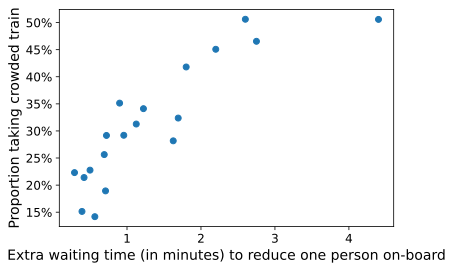

In [8]:
# BVOC - Choice scatter plot
tookCrowded = (choiceData.groupby(['bvoc'])['tookCrowded'].sum()/choiceData.groupby(['bvoc'])['tookCrowded'].count()).reset_index()
fig, ax = plt.subplots()
ax.scatter(tookCrowded['bvoc'],tookCrowded['tookCrowded'])
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1,decimals=0))
plt.xlabel('Extra waiting time (in minutes) to reduce one person on-board')
plt.ylabel('Proportion taking crowded train')
plt.show()

Opt out characteristics

Always fully opt-out respondents: 22
Never opt-out respondents: 65


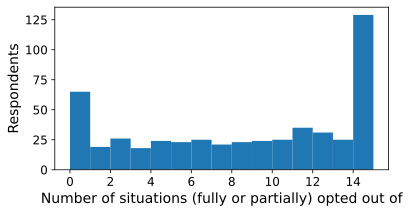

In [9]:
num_situations_per_respondent = 15
optoutSum = choiceData.groupby('respondentId')['optoutRank'].sum()
print('Always fully opt-out respondents:',len(optoutSum.loc[optoutSum==1*num_situations_per_respondent]))
print('Never opt-out respondents:',len(optoutSum.loc[optoutSum==3*num_situations_per_respondent]))

fig, ax = plt.subplots(figsize=(6,3))
ax.hist(choiceData[['respondentId','optedOut']].groupby('respondentId').sum().values, bins=range(num_situations_per_respondent+1))
plt.ylabel('Respondents')
plt.xlabel('Number of situations (fully or partially) opted out of')
plt.show()


## Personal Characteristics

In [10]:
# Merge other characteristics
individual_cols = [
                    # Personal
                    'Age','Gender', 'Edu', 'Occupation', 'WfhBeforeCOVID', 'WfhDuringCOVID',
                    'WfhAfterCOVID', 'WfhEffective', 'GrossIncome', 'HouseholdSize',
                    'HH0_5', 'HH6_11', 'HH12_17', 'HH18_24', 'HH25-34', 'HH35_44',
                    'HH45_54', 'HH55_64', 'HH65_74', 'HH75_84', 'HH85_94', 'HH94plus',
                    'Urbanity', 'ZipCode',
                    
                    # Mobility
                    'TrnFreqBeforeCOVID', 'TrnFreqDuringCOVID', 'TrnPurposeBeforeCOVID', 'PTAlt', 
                    'CrowdingBeforeCOVID', 'CrowdingDuringCOVID',
                    
                    # COVID
                    'InfectionRateBelief', 'Worried', 'IWillGetCOVID', 'IWillBeHosp',
                    'IWillInfectHH', 'HHWillBeHosp', 'TrustGovt', 'TrustRIVM',
                    'Facemask', 'Distancing', 'SymptomHygiene', 'HandSanitize',
                    'OthersFollowRule', 'IFollowRules', 'COVIDInfoFreq'
                     ]

individual = data_num.loc[:,individual_cols].reset_index().rename(columns={'index':'respondentId'})

# Create features
individual['HHhas65plus'] = (individual[['HH65_74','HH75_84','HH85_94','HH94plus']].sum(axis=1)>0).astype(int).values
individual['hasPTAlt'] = (individual['PTAlt']!=7).astype(int).values
individual['isFemale'] = (individual['Gender']==1).astype(int).values
individual['isCommuter'] = (individual['TrnPurposeBeforeCOVID'].isin([1,2])).astype(int).values
individual['optoutPropensity'] = choiceData.groupby('respondentId')['optoutRank'].mean()
individual['tookCrowdedPropensity'] = choiceData.groupby('respondentId')['tookCrowded'].mean()


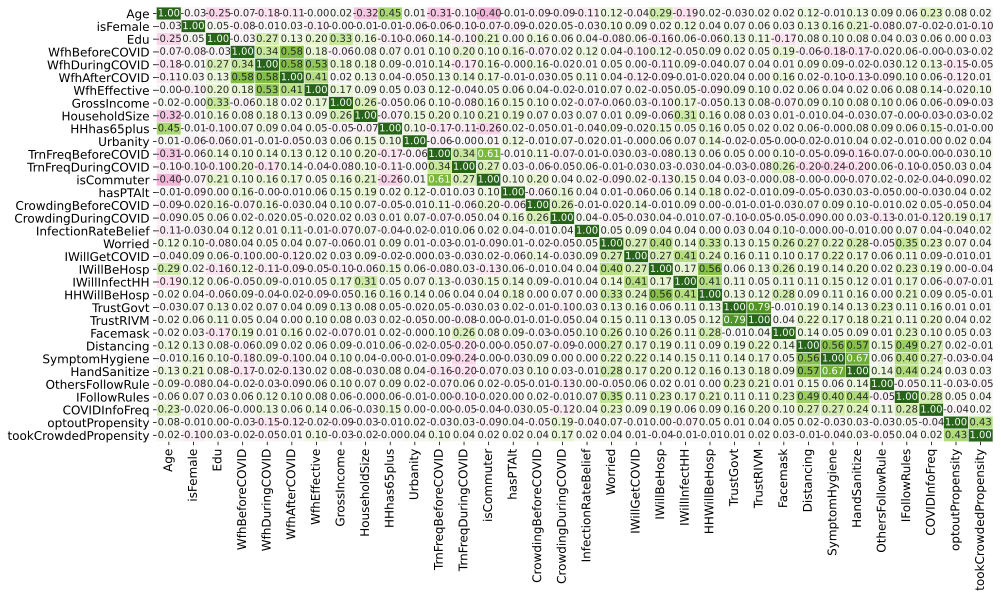

In [11]:
individual_cols = [
    # Personal
    'Age','isFemale', 'Edu', 'WfhBeforeCOVID', 'WfhDuringCOVID',
    'WfhAfterCOVID', 'WfhEffective', 'GrossIncome', 'HouseholdSize',
    'HHhas65plus','Urbanity',

    # Mobility
    'TrnFreqBeforeCOVID', 'TrnFreqDuringCOVID', 'isCommuter', 'hasPTAlt', 
    'CrowdingBeforeCOVID', 'CrowdingDuringCOVID',

    # COVID
    'InfectionRateBelief', 'Worried', 'IWillGetCOVID', 'IWillBeHosp',
    'IWillInfectHH', 'HHWillBeHosp', 'TrustGovt', 'TrustRIVM',
    'Facemask', 'Distancing', 'SymptomHygiene', 'HandSanitize',
    'OthersFollowRule', 'IFollowRules', 'COVIDInfoFreq',

    # Choice
    'optoutPropensity','tookCrowdedPropensity'

]
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    individual[individual_cols].corr(), annot=True, fmt='.2f', linewidths=.5, ax=ax, 
    vmin=-1, vmax=1,cmap="PiYG", cbar=False
)
plt.show()

## Seat Choice Data

In [12]:
crowding_levels = 5
num_seats = 40

# Seating choices to merge with choice table
seatChoice = pd.DataFrame(columns=['Seat_'+str(i+1) for i in range(crowding_levels)],index=data_txt.index)

for sit in range(crowding_levels):
    seatChoiceSit = data_txt.filter(regex='Seat_'+str(sit+1)+'_\d*').replace(['Off','On'],[False,True])
    seatChoiceCols = [int(i.split('_')[-1]) for i in seatChoiceSit.columns]
    seatChoiceSit.columns = seatChoiceCols
    seatChoice.loc[:,'Seat_'+str(sit+1)] = seatChoiceSit.apply(lambda x: x.index[x][0], axis=1).values


# Get seat characteristics
seat_char = pd.read_excel(os.path.join(DATA_PATH, 'seatCharacteristics.xlsx'))
seat_char = seat_char.set_index(['sit','char']).transpose()

# Merge seat characteristics to seat choices
seatCharSitList = []
for i in range(crowding_levels):
    seatCharSit = seat_char.loc[seatChoice['Seat_'+str(i+1)].values,i+1].reset_index(drop=True)
    seatCharSit.columns = [j+'_'+str(i+1) for j in seatCharSit]
    # display(seatCharSit)
    seatCharSitList += [seatCharSit]

seatChar = pd.concat(seatCharSitList,axis=1)
seatChar.index = seatChoice.index
seatChoice = pd.concat([seatChoice, seatChar],axis=1)
seatChoice = seatChoice.reset_index().rename(columns={'index':'respondentId'})


Situation 1


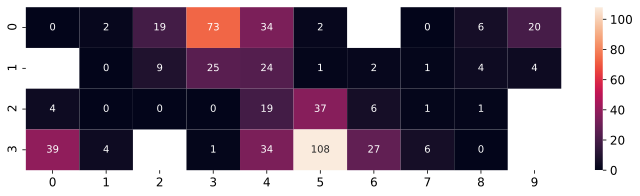

Situation 2


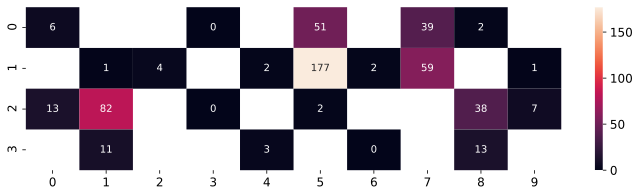

Situation 3


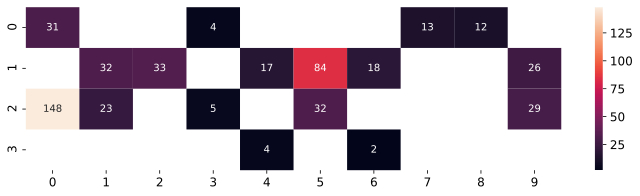

Situation 4


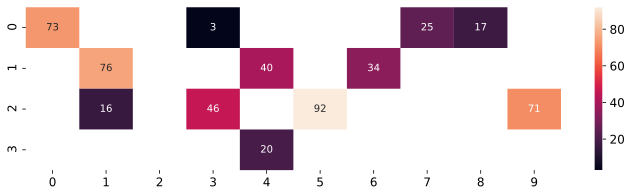

Situation 5


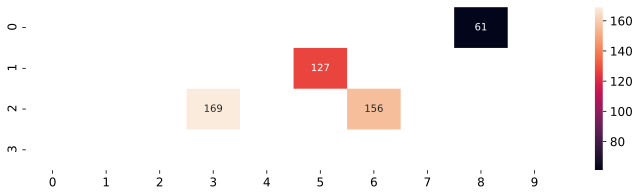

In [13]:
# Seating data for heatmap
seatSit = np.zeros((crowding_levels,num_seats,len(data_txt)),int) # situation, seat, respondent

# Add unavailable seats
seatSitAvail = np.zeros((5,40),int) # situation, seat, respondent
seatSitAvail[0,np.array([2,13,26,39,40])-1] = -1 # -1 in index is to correct for 0-index
seatSitAvail[1,np.array([2,3,5,8,9,13,18,19,
                  22,25,26,28,29,32,33,35,36,40])-1] = -1
seatSitAvail[2,np.array([2,3,5,8,9,11,13,16,18,19,
                  22,24,25,26,28,29,32,33,35,36,37,38,40])-1] = -1
seatSitAvail[3,:] = -1
seatSitAvail[3,np.array([1,4,7,10,14,15,17,
                  23,27,30,31,39])-1] = 0
seatSitAvail[4,:] = -1
seatSitAvail[4,np.array([12,27,17,33])-1] = 0

for sit in range(crowding_levels):
    seatChoiceSit = data_txt.filter(regex='Seat_'+str(sit+1)+'_\d*').replace(['Off','On'],[False,True])
    seatChoiceCols = [int(i.split('_')[-1]) for i in seatChoiceSit.columns]
    seatChoiceSit.columns = seatChoiceCols
    for seat in seatChoiceCols:
        seatSit[sit,seat-1,:] = seatChoiceSit[seat].values

seatChoiceSum = seatSit.sum(axis=2)

for sit in range(crowding_levels):
    print('Situation '+str(sit+1))
    seatChoiceSum[sit,seatSitAvail[sit,:]<0] = -1
    dat = np.vstack([seatChoiceSum[sit][0:20:2],
                     seatChoiceSum[sit][1:20:2],
                     seatChoiceSum[sit][20:40:2],
                     seatChoiceSum[sit][21:40:2]])
    fig, ax = plt.subplots(figsize=(12,3))
    sns.heatmap(dat, mask = dat<0, annot=True, fmt='d', cbar=True)
    plt.show()


## Merge Data

In [15]:
data = pd.merge(choiceData, individual, on='respondentId', how='left')
data = pd.merge(data, seatChoice, on='respondentId', how='left')

display(data)

,respondentId,sitId,train1Rank,train2Rank,optoutRank,trainChoice,optedOut,rank1Choice,rank2Choice,rank2av_1,...,window_4,groupOf4_4,frontFacing_4,distLeftEntry_4,alone_4,window_5,groupOf4_5,frontFacing_5,distLeftEntry_5,alone_5
0,4,4,1.0,3.0,2.0,1,1,1,3,0,...,1,0,1,4,0,0,0,1,5,0
1,4,7,2.0,1.0,3.0,2,0,2,1,1,...,1,0,1,4,0,0,0,1,5,0
2,4,8,1.0,3.0,2.0,1,1,1,3,0,...,1,0,1,4,0,0,0,1,5,0
3,4,11,1.0,2.0,3.0,1,0,1,2,0,...,1,0,1,4,0,0,0,1,5,0
4,4,13,2.0,1.0,3.0,2,0,2,1,1,...,1,0,1,4,0,0,0,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,567,38,3.0,2.0,1.0,2,1,3,2,1,...,0,1,0,1,0,0,1,0,3,0
7691,567,40,3.0,2.0,1.0,2,1,3,2,1,...,0,1,0,1,0,0,1,0,3,0
7692,567,42,3.0,1.0,2.0,2,1,2,3,1,...,0,1,0,1,0,0,1,0,3,0
7693,567,54,2.0,3.0,1.0,1,1,3,1,1,...,0,1,0,1,0,0,1,0,3,0


# Modelling

## Feature Selection

In [30]:
ordinal_cols = [ # Commented features have missing values
    'Age', 'Edu', 'Occupation', 'GrossIncome', 
    # 'WfhBeforeCOVID', 'WfhDuringCOVID', 'WfhAfterCOVID', 'WfhEffective', # missing because not everyone works
    'TrnFreqBeforeCOVID', 'TrnFreqDuringCOVID', 'CrowdingBeforeCOVID', 
    # 'CrowdingDuringCOVID', # because not everyone used trains during COVID
    'Worried', 'IWillGetCOVID', 'IWillBeHosp',
    'IWillInfectHH', 'HHWillBeHosp', 
    # 'TrustGovt', # was an optional question (by mistake) and people skipped it
    'TrustRIVM',
    'Facemask', 'Distancing', 'SymptomHygiene', 'HandSanitize',
    'OthersFollowRule', 'IFollowRules', 'COVIDInfoFreq',
]

categorical_cols = [
     'HHhas65plus', 'hasPTAlt', 'isFemale', 'isCommuter',
]

numerical_cols = [
    'Urbanity','InfectionRateBelief'
]

target_col = 'rank1Choice'

X = data[ordinal_cols + categorical_cols + numerical_cols]
y = data[target_col]
# display(X,y)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7695 entries, 0 to 7694
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  7695 non-null   float64
 1   Edu                  7695 non-null   float64
 2   Occupation           7695 non-null   float64
 3   GrossIncome          7695 non-null   float64
 4   TrnFreqBeforeCOVID   7695 non-null   int64  
 5   TrnFreqDuringCOVID   7695 non-null   float64
 6   CrowdingBeforeCOVID  7695 non-null   float64
 7   Worried              7695 non-null   float64
 8   IWillGetCOVID        7695 non-null   float64
 9   IWillBeHosp          7695 non-null   float64
 10  IWillInfectHH        7695 non-null   float64
 11  HHWillBeHosp         7695 non-null   float64
 12  TrustRIVM            7695 non-null   float64
 13  Facemask             7695 non-null   float64
 14  Distancing           7695 non-null   float64
 15  SymptomHygiene       7695 non-null   f

In [32]:
# Data prep pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline
class MostFreqCat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

categorical_pipeline = Pipeline([
    ('imputer', MostFreqCat())#,
    # ('oneHotEncoder', OneHotEncoder(sparse=False))
])

full_pipeline = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_cols),
    ('categorical', categorical_pipeline, ordinal_cols + categorical_cols)
])

X_transformed = full_pipeline.fit_transform(X)


In [36]:
np.shape(X_transformed)

(7695, 26)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
display(X_train,y_train)

array([[  4.33333333,  40.        ,   4.        , ...,   1.        ,
          0.        ,   1.        ],
       [  1.58333333,  40.        ,   5.        , ...,   1.        ,
          1.        ,   0.        ],
       [  5.        , 100.        ,   3.        , ...,   1.        ,
          1.        ,   0.        ],
       ...,
       [  3.75      , 100.        ,   6.        , ...,   0.        ,
          1.        ,   0.        ],
       [  1.        ,  50.        ,   5.        , ...,   1.        ,
          0.        ,   1.        ],
       [  4.33333333,  35.        ,   2.        , ...,   1.        ,
          0.        ,   1.        ]])

947     2
2845    3
2926    3
4629    2
4450    2
       ..
5226    1
5390    1
860     1
7603    2
7270    1
Name: rank1Choice, Length: 5386, dtype: int64

In [20]:
np.array(data.columns)

array(['respondentId', 'sitId', 'train1Rank', 'train2Rank', 'optoutRank',
       'trainChoice', 'optedOut', 'rank1Choice', 'rank2Choice',
       'rank2av_1', 'rank2av_2', 'rank2av_3', 'trn1Crowd', 'trn1Wt',
       'trn2Crowd', 'trn2Wt', 'infect', 'ivt', 'tookCrowded', 'bvoc',
       'Age', 'Gender', 'Edu', 'Occupation', 'WfhBeforeCOVID',
       'WfhDuringCOVID', 'WfhAfterCOVID', 'WfhEffective', 'GrossIncome',
       'HouseholdSize', 'HH0_5', 'HH6_11', 'HH12_17', 'HH18_24',
       'HH25-34', 'HH35_44', 'HH45_54', 'HH55_64', 'HH65_74', 'HH75_84',
       'HH85_94', 'HH94plus', 'Urbanity', 'ZipCode', 'TrnFreqBeforeCOVID',
       'TrnFreqDuringCOVID', 'TrnPurposeBeforeCOVID', 'PTAlt',
       'CrowdingBeforeCOVID', 'CrowdingDuringCOVID',
       'InfectionRateBelief', 'Worried', 'IWillGetCOVID', 'IWillBeHosp',
       'IWillInfectHH', 'HHWillBeHosp', 'TrustGovt', 'TrustRIVM',
       'Facemask', 'Distancing', 'SymptomHygiene', 'HandSanitize',
       'OthersFollowRule', 'IFollowRules', 'COVIDInf

In [18]:
from sklearn.model_selection import train_test_split

X = choiceData.drop('rank1Choice',axis=1)
y = choiceData['rank1Choice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train,y_train)

,respondentId,sitId,train1Rank,train2Rank,optoutRank,trainChoice,optedOut,rank2Choice,rank2av_1,rank2av_2,rank2av_3,trn1Crowd,trn1Wt,trn2Crowd,trn2Wt,infect,ivt,tookCrowded,bvoc
947,76,19,2.0,1.0,3.0,2,0,1,1,0,1,23,25,28,3,0.1,10,True,4.400000
2845,214,32,2.0,3.0,1.0,1,1,1,1,1,0,23,3,18,25,20.0,25,True,4.400000
2926,220,15,2.0,3.0,1.0,1,1,1,1,1,0,5,25,36,3,100.0,25,False,0.709677
4629,345,43,2.0,1.0,3.0,2,0,1,1,0,1,28,3,5,25,1.0,10,False,0.956522
4450,332,42,2.0,1.0,3.0,2,0,1,1,0,1,36,3,5,12,1.0,10,False,0.290323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,385,30,1.0,3.0,2.0,1,1,3,0,1,1,5,12,18,3,100.0,40,False,0.692308
5390,398,16,1.0,2.0,3.0,1,0,2,0,1,1,23,12,28,3,20.0,25,False,1.800000
860,70,16,1.0,2.0,3.0,1,0,2,0,1,1,23,12,28,3,20.0,25,False,1.800000
7603,561,51,2.0,1.0,3.0,2,0,1,1,0,1,28,3,18,12,100.0,40,False,0.900000


947     2
2845    3
2926    3
4629    2
4450    2
       ..
5226    1
5390    1
860     1
7603    2
7270    1
Name: rank1Choice, Length: 5386, dtype: int64

# Models

In [ ]:
from sklearn